In [4]:
# !pip install leafmap

In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import seaborn as sns

# Leafmap Folium wrapper
import leafmap.foliumap as leafmap


In [ ]:
# Settings for sns plot
sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)


In [38]:
# Point to your GeoTIFF here
# TIF_PATH = "/projects/my-private-bucket/HLS-1DCNN-AGB/data/tif/HLS_composites/monthly/br_af_grid60km_prj_evi2_max/tile_197/2022/HLS_197_04-01_04-30_2022_2022_maxevi2.tif"
TIF_PATH = "/projects/my-private-bucket/HLS-1DCNN-AGB/data/tif/HLS_composites/monthly/br_af_grid60km_prj_evi2_max/tile_197/2022/HLS_197_08-01_08-31_2022_2022_maxevi2.tif"



In [39]:
# ========= 2) Open with xarray/rioxarray & basic metadata =========
# Use rioxarray to keep georeferencing intact
da = rxr.open_rasterio(TIF_PATH, masked=True)  # DataArray with dims: (band, y, x) or (y, x) if single-band


In [40]:
da

<xarray.DataArray (band: 23, y: 2000, x: 2000)> Size: 736MB
[92000000 values with dtype=float64]
Coordinates:
  * band         (band) int64 184B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23
  * x            (x) float64 16kB 5.499e+06 5.499e+06 ... 5.559e+06 5.559e+06
  * y            (y) float64 16kB 7.284e+06 7.284e+06 ... 7.224e+06 7.224e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  NEAREST
    AREA_OR_POINT:       Area
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2', 'ND...

In [41]:
# # Standardize band dimension name
# if "band" not in da.dims and da.ndim == 3:
#     da = da.rename({da.dims[0]: "band"})


In [42]:
# Summary ain attributes
print("Dtype:", da.dtype)
print("Shape:", tuple(da.shape), " (dims:", da.dims, ")")
print("CRS:", da.rio.crs)
print("Resolution (x, y):", da.rio.resolution())
print("Nodata value:", da.rio.nodata)


Dtype: float64
Shape: (23, 2000, 2000)  (dims: ('band', 'y', 'x') )
CRS: EPSG:5880
Resolution (x, y): (30.0, -30.0)
Nodata value: nan


In [43]:
da.dims

('band', 'y', 'x')

In [44]:
# Per-band quick stats
# for b in da.band.values:
#     vals = da.sel(band = b).values
#     finite = np.isfinite(vals)
#     q = np.nanpercentile(vals[finite], [2, 50, 98]) if finite.any() else [np.nan]*3
#     print(f"Band {int(b)}: min={np.nanmin(vals):.3f}, median={q[1]:.3f}, max={np.nanmax(vals):.3f}, q02/98=({q[0]:.3f}, {q[2]:.3f})")


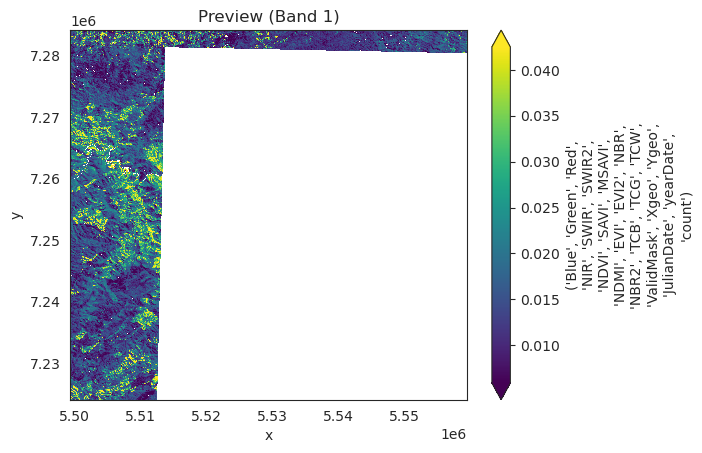

In [45]:
# ========= 3) Quicklooks with xarray/matplotlib =========
# Single-band preview (or show first band)
first = da.isel(band=0)
first.plot.imshow(robust=True)  # robust=True uses 2–98% stretch
plt.title("Preview (Band 1)")
plt.show()



In [30]:
da.attrs['long_name']

('Blue',
 'Green',
 'Red',
 'NIR',
 'SWIR',
 'SWIR2',
 'NDVI',
 'SAVI',
 'MSAVI',
 'NDMI',
 'EVI',
 'EVI2',
 'NBR',
 'NBR2',
 'TCB',
 'TCG',
 'TCW',
 'ValidMask',
 'Xgeo',
 'Ygeo',
 'JulianDate',
 'yearDate',
 'count')

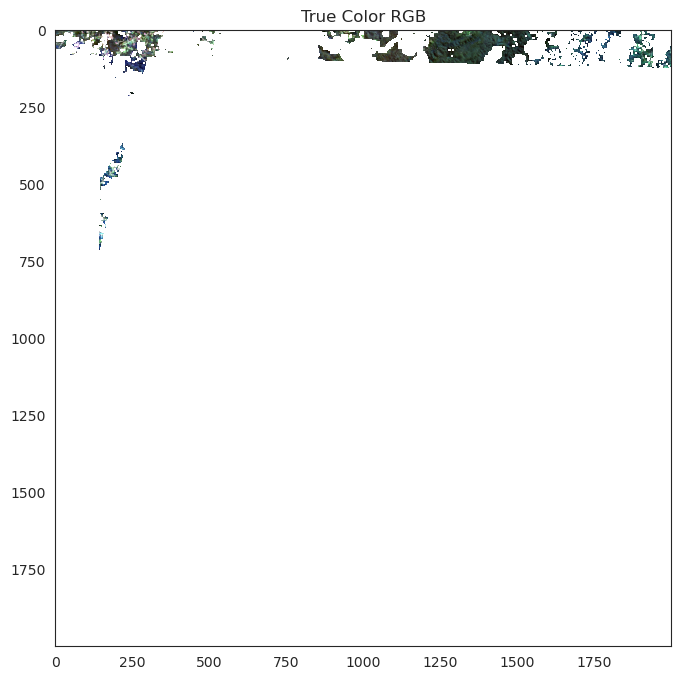

In [35]:
# Select bands: Red=3, Green=2, Blue=1
red   = da.sel(band=3).values
green = da.sel(band=2).values
blue  = da.sel(band=1).values

# Stretch each band (2–98% percentile)
def stretch(arr):
    lo, hi = np.nanpercentile(arr, [2, 98])
    return np.clip((arr - lo) / (hi - lo + 1e-9), 0, 1)

rgb = np.dstack([stretch(red), stretch(green), stretch(blue)])

# Plot with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("True Color RGB")
# plt.axis("off")
plt.show()

In [36]:
!pwd

/projects/my-private-bucket/HLS-1DCNN-AGB/code/data_exploration



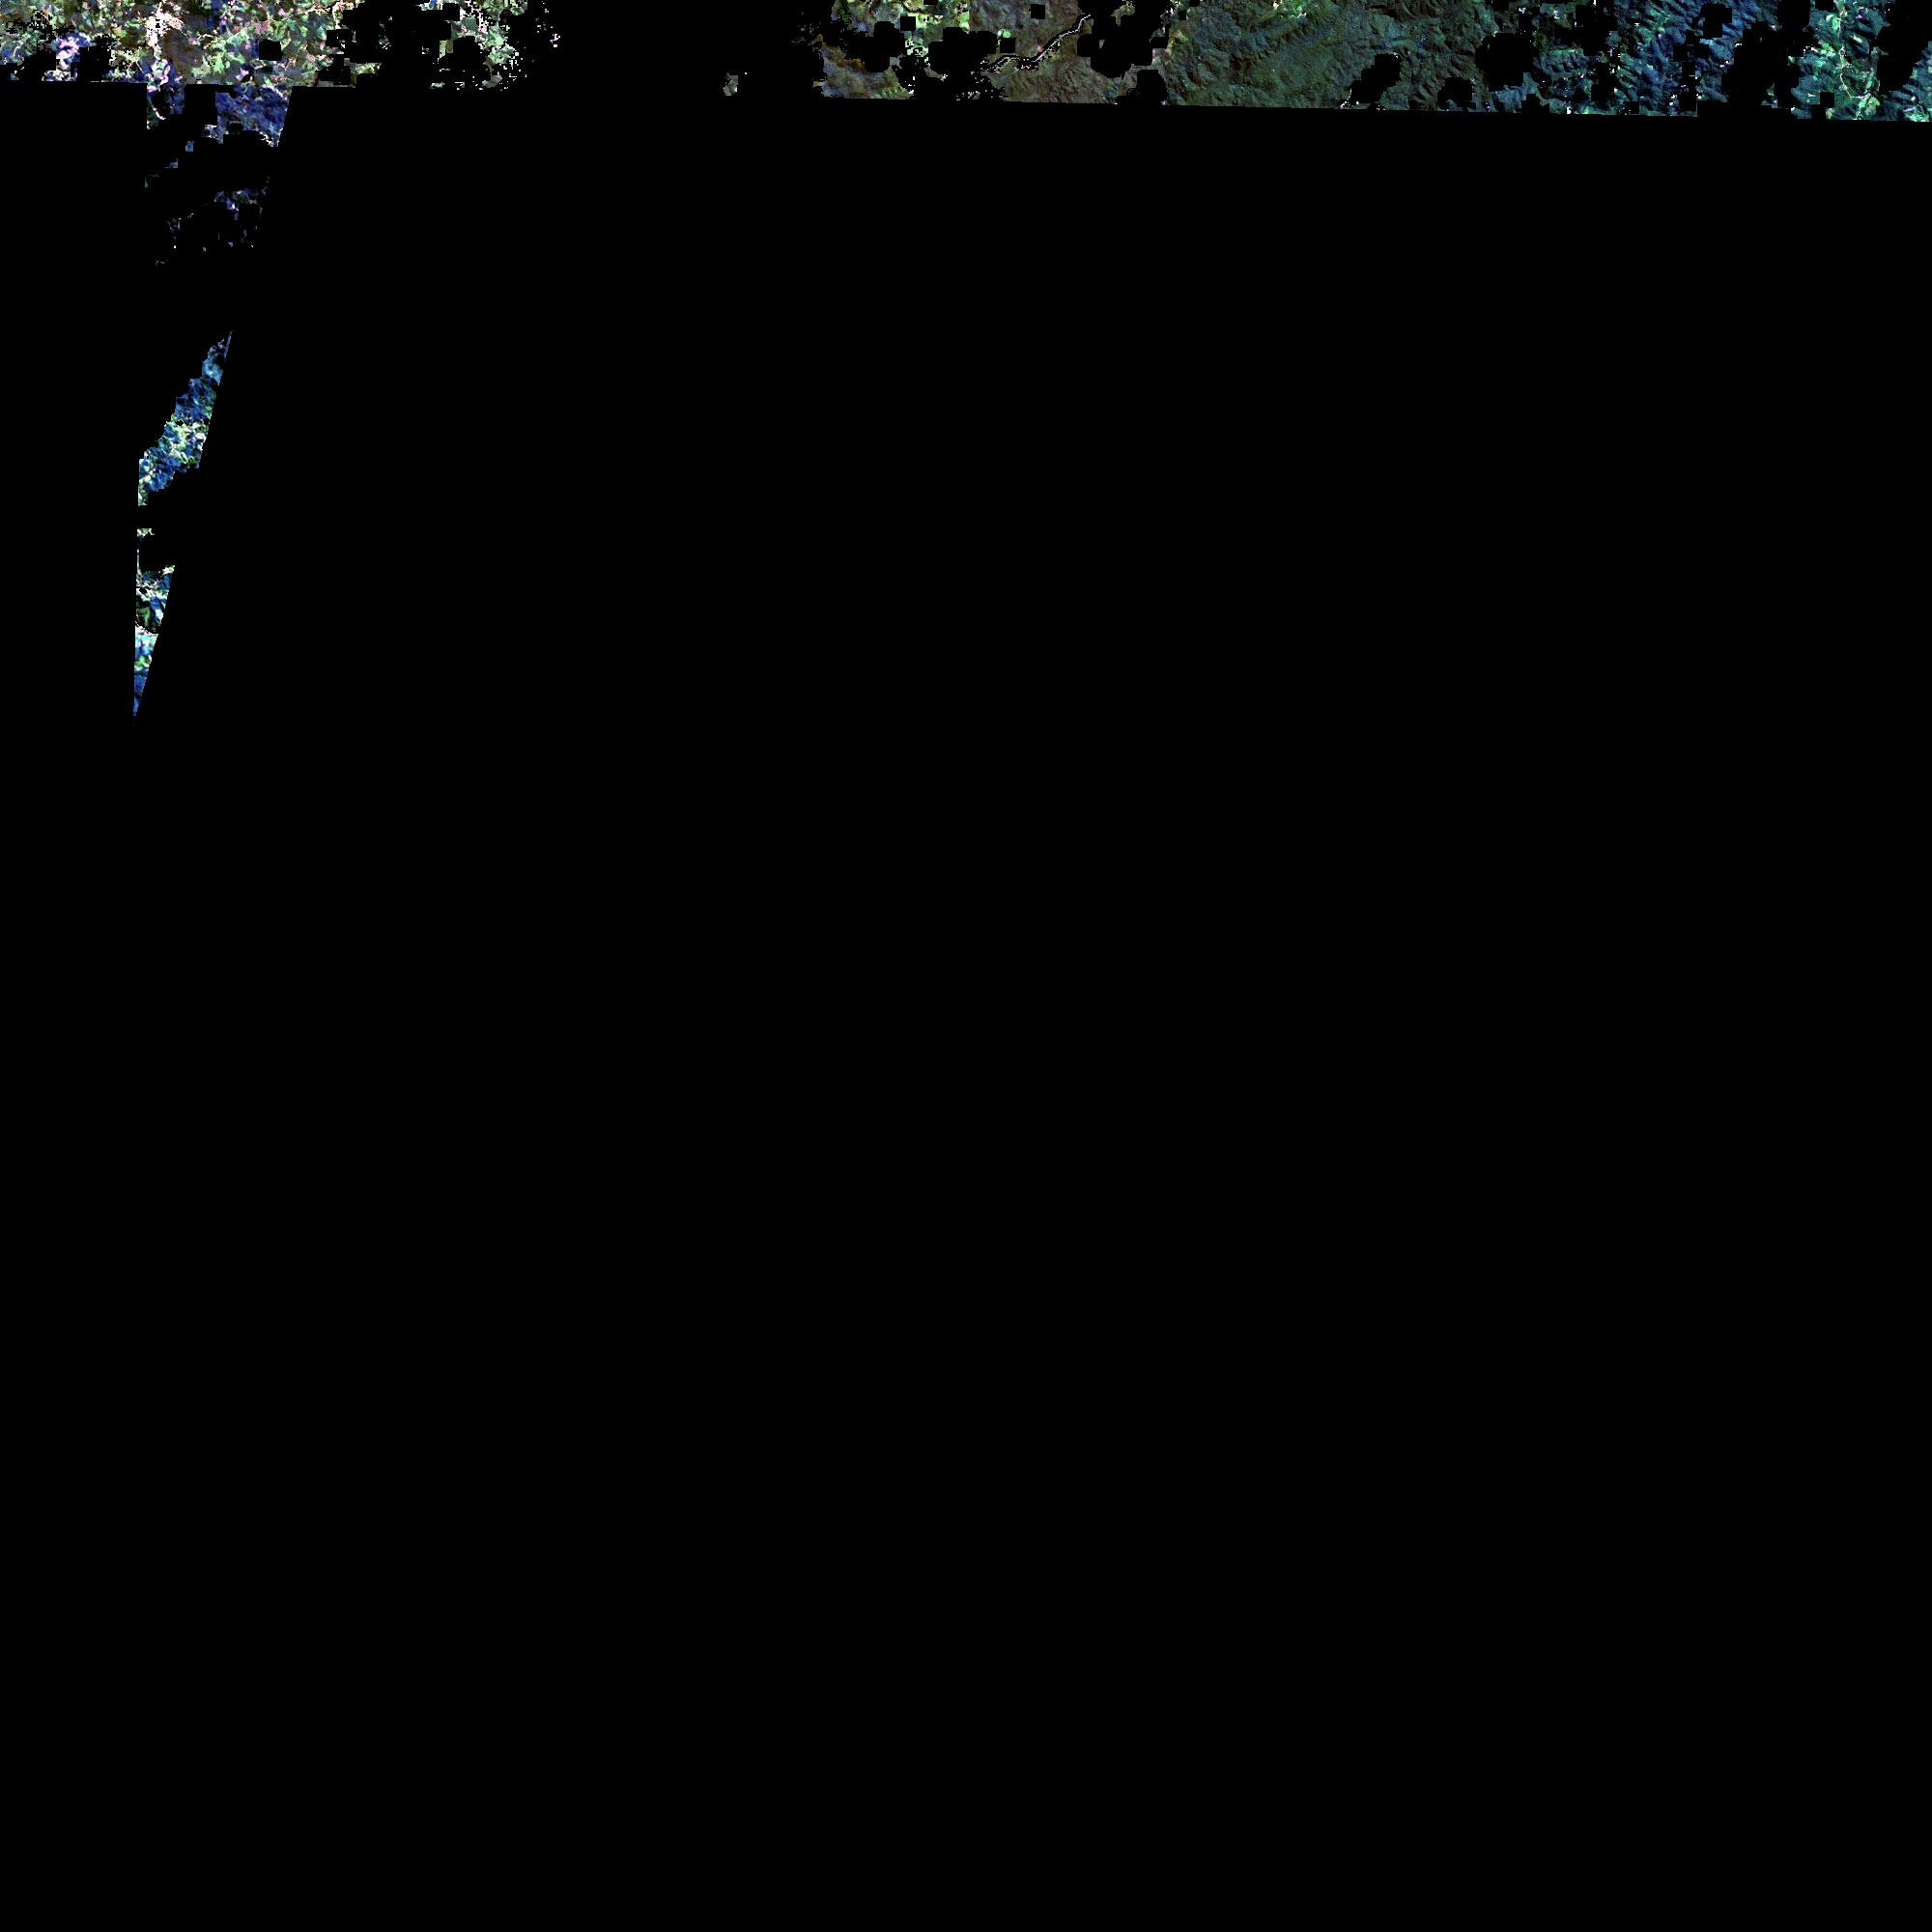

In [37]:
import folium
import imageio

# Save RGB composite to PNG
imageio.imwrite("rgb.png", (rgb*255).astype("uint8"))

# Get geographic bounds in EPSG:4326
minx, miny, maxx, maxy = da.rio.transform_bounds("EPSG:4326")
bounds = [[miny, minx], [maxy, maxx]]

# Center
center_lat = (miny + maxy)/2
center_lon = (minx + maxx)/2

# Create folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles="OpenStreetMap")

folium.raster_layers.ImageOverlay(
    image="rgb.png",
    bounds=bounds,
    name="RGB",
    opacity=0.85
).add_to(m)

folium.LayerControl().add_to(m)
m


# Rasterio

In [28]:
# ========= 7) (Optional) Fast windowed reads with rasterio (e.g., for very large files) =========
# Example: read a 1024x1024 window from the center and preview
with rasterio.open(TIF_PATH) as src:
    h, w = src.height, src.width
    win_size = 1024
    row_off = max(0, (h - win_size) // 2)
    col_off = max(0, (w - win_size) // 2)
    print(h)
    print(w)
    print(row_off)
    print(col_off)
    window = rasterio.windows.Window(col_off=col_off, row_off=row_off, 
                                     width=min(win_size, w), 
                                     height=min(win_size, h))
    arr = src.read(window=window)  # shape: (bands, win_h, win_w)


2000
2000
488
488


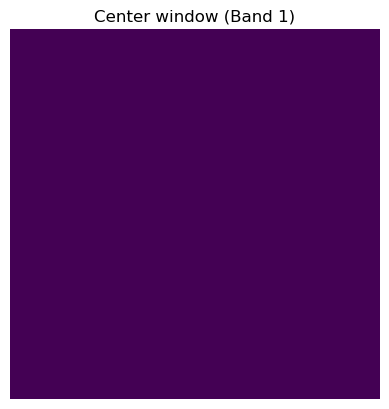

In [27]:

# Show first band of the window
plt.imshow(arr[0, :, :], interpolation="nearest")
plt.title("Center window (Band 1)")
plt.axis("off")
plt.show()
